In [42]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Load our dataset

In [46]:
df = pd.read_csv('data/apartment.csv')

# 1. Cleaning data
***

First and foremost, a overview of our dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   apartment_id       3364 non-null   int64  
 1   name               3364 non-null   object 
 2   num_bedrooms       3364 non-null   int64  
 3   num_bathrooms      3364 non-null   int64  
 4   num_beds           3364 non-null   int64  
 5   area               3326 non-null   float64
 6   maximum_guests     3364 non-null   int64  
 7   rating             3364 non-null   int64  
 8   review_count       3364 non-null   int64  
 9   like_count         3364 non-null   int64  
 10  bedType_name       3356 non-null   object 
 11  roomType_name      3364 non-null   object 
 12  propertyType_name  3364 non-null   object 
 13  nightly_price_vnd  3364 non-null   float64
 14  ward               2416 non-null   object 
 15  district           3360 non-null   object 
 16  city               3364 

### Look at this tables, we can extract some important information
- Some columns have missing record: area, bedType_name, ward, district
- The data type for each columns are not optimised for memory usage
- Some variables does not bring much value to our analysis or modeling: apartment_id, name

### We will deal with each of these step by step
***

Due to the data collection process, there might be some duplicates, remove them as such

In [4]:
df.drop_duplicates(subset='apartment_id', inplace=True)

Fill missing value with a median value

In [5]:
# area
df['area'].fillna(df['area'].median(), inplace=True)
# bedType_name
df['bedType_name'].fillna(df['bedType_name'].mode()[0], inplace=True)
# ward
df['district'].fillna(df['district'].mode()[0], inplace=True)
# ward
df['ward'].fillna(df['ward'].mode()[0], inplace=True)

The data only has one city (HCMC) as the whole column value, drop 'city' column

In [6]:
df.drop(columns='city', inplace=True)

Apartment_id and names are irrelevant, also drop

In [ ]:
df.drop(columns=['apartment_id','name'], inplace=True)

Amenities format are not good for analysis, a record is a whole string instead of a list of string

In [49]:
# convert each record of amenities to a list of string
import re
for idx, amenities in enumerate(df['amenities']):
    re_obj = re.findall(r'"(.+?)"', amenities)
    df['amenities'].loc[idx] = re_obj

/home/thieenq/.local/share/virtualenvs/interactive_plots-xAs2dAJo/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Convert to proper type to conserve memory

In [8]:
df['num_bedrooms'] = df['num_bedrooms'].astype('int32')
df['num_bathrooms'] = df['num_bathrooms'].astype('int32')
df['num_beds'] = df['num_beds'].astype('int32')
df['area'] = df['area'].astype('int32')
df['maximum_guests'] = df['maximum_guests'].astype('int32')
df['rating'] = df['rating'].astype('int32')
df['review_count'] = df['review_count'].astype('int32')
df['like_count'] = df['like_count'].astype('int32')
df['bedType_name'] = df['bedType_name'].astype('category')
df['roomType_name'] = df['roomType_name'].astype('category')
df['propertyType_name'] = df['propertyType_name'].astype('category')
df['ward'] = df['ward'].astype('category')
df['district'] = df['district'].astype('category')

In [9]:
# much better
df.memory_usage()

Index                101288
num_bedrooms           9684
num_bathrooms          9684
num_beds               9684
area                   9684
maximum_guests         9684
rating                 9684
review_count           9684
like_count             9684
bedType_name           2805
roomType_name          2517
propertyType_name      2629
nightly_price_vnd     19368
ward                   5445
district               3221
latitude              19368
longitude             19368
amenities             19368
dtype: int64

**Overall dataset after cleaning**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421 entries, 0 to 3363
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   num_bedrooms       2421 non-null   int32   
 1   num_bathrooms      2421 non-null   int32   
 2   num_beds           2421 non-null   int32   
 3   area               2421 non-null   int32   
 4   maximum_guests     2421 non-null   int32   
 5   rating             2421 non-null   int32   
 6   review_count       2421 non-null   int32   
 7   like_count         2421 non-null   int32   
 8   bedType_name       2421 non-null   category
 9   roomType_name      2421 non-null   category
 10  propertyType_name  2421 non-null   category
 11  nightly_price_vnd  2421 non-null   float64 
 12  ward               2421 non-null   category
 13  district           2421 non-null   category
 14  latitude           2421 non-null   float64 
 15  longitude          2421 non-null   float64 
 16  amenit

In [11]:
df.head()

,num_bedrooms,num_bathrooms,num_beds,area,maximum_guests,rating,review_count,like_count,bedType_name,roomType_name,propertyType_name,nightly_price_vnd,ward,district,latitude,longitude,amenities
0,1,1,1,25,2,5,2,7,Real Bed,Nguyên căn,Căn hộ dịch vụ,4.337223e+05,Phường 2,Quận 5,10.759348,106.684093,"[Tủ lạnh, Cảnh quan đẹp, Wifi, TV, Phù hợp với..."
1,1,1,1,40,3,3,11,13,Queen Size,Nguyên căn,Nhà riêng,7.063881e+05,Phường 22,Quận 1,10.774437,106.700235,"[Bếp điện, Lò vi sóng, Tủ lạnh, Wifi, Ban Công..."
2,1,1,1,39,2,0,0,1,Queen Size,Phòng riêng,Căn hộ Studio,7.143938e+05,Tân Hưng,Quận 7,10.745375,106.701551,"[Lò vi sóng, Tủ lạnh, Cảnh quan đẹp, Wifi, Ban..."
3,2,2,3,100,7,4,11,5,Queen Size,Nguyên căn,Căn hộ chung cư,1.836845e+06,Đa Kao,Quận 1,10.784133,106.698292,"[BBQ, Bếp điện, Lò vi sóng, Tủ lạnh, Wifi, Ban..."
4,1,1,1,36,3,0,0,4,Queen Size,Nguyên căn,Căn hộ chung cư,8.163492e+05,Phường 22,Bình Thạnh,10.793400,106.717649,"[BBQ, Lò vi sóng, Tủ lạnh, Cảnh quan đẹp, Gần ..."


# 2. Exploratory Data Analysis
***

In this section, we'll mainly focus on the price, specifically the nightly price of each location

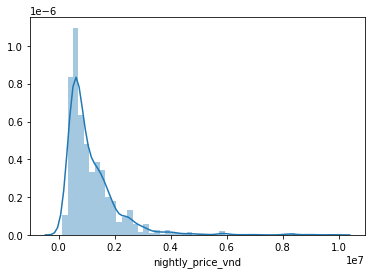

In [12]:
# let's check out its distribution

sns.distplot(df['nightly_price_vnd'])

**INSIGHT**
***
- Definitely not a normal distribution
- A bit skewed to the left
- Got a very sharp peak

Let's check out it's stats

In [13]:
df['nightly_price_vnd'].describe()

count    2.421000e+03
mean     1.169793e+06
std      9.517443e+05
min      1.276208e+05
25%      5.658169e+05
50%      8.674446e+05
75%      1.504371e+06
max      9.795955e+06
Name: nightly_price_vnd, dtype: float64

This seems normal, there's no weird record where the price is negative. Which is good for our model later

## 2a. Relationship with numerical values
***

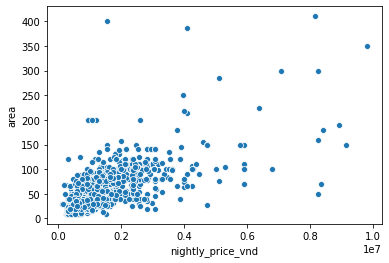

In [14]:
sns.scatterplot(x='nightly_price_vnd', y='area', data=df)

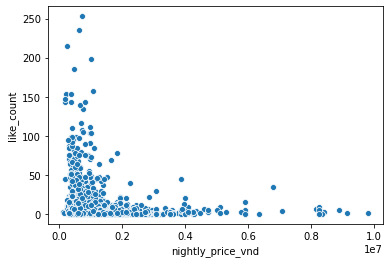

In [15]:
sns.scatterplot(x='nightly_price_vnd', y='like_count', data=df)

## 2b. Relationship with categorical values
***

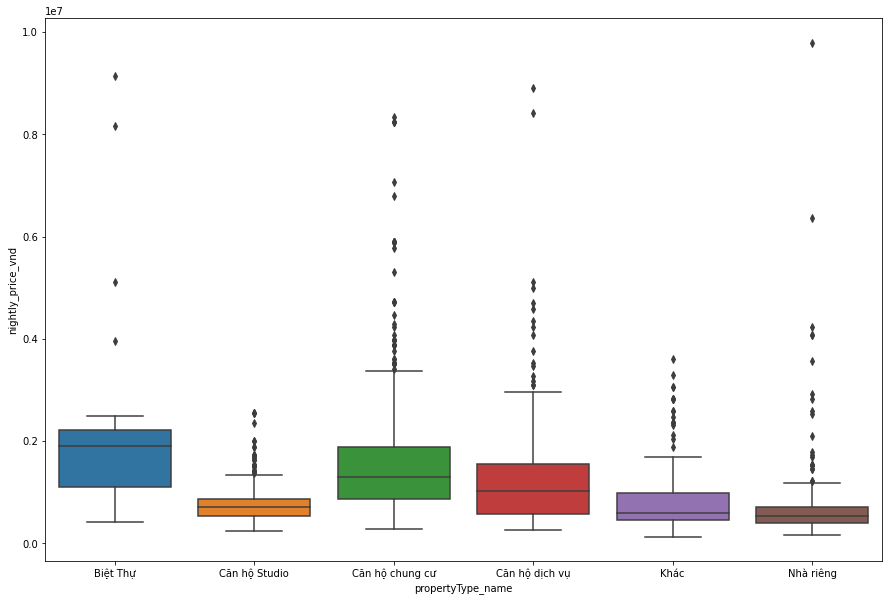

In [16]:
plt.figure(figsize=(15,10))
sns.boxplot(x='propertyType_name', y='nightly_price_vnd', data=df)

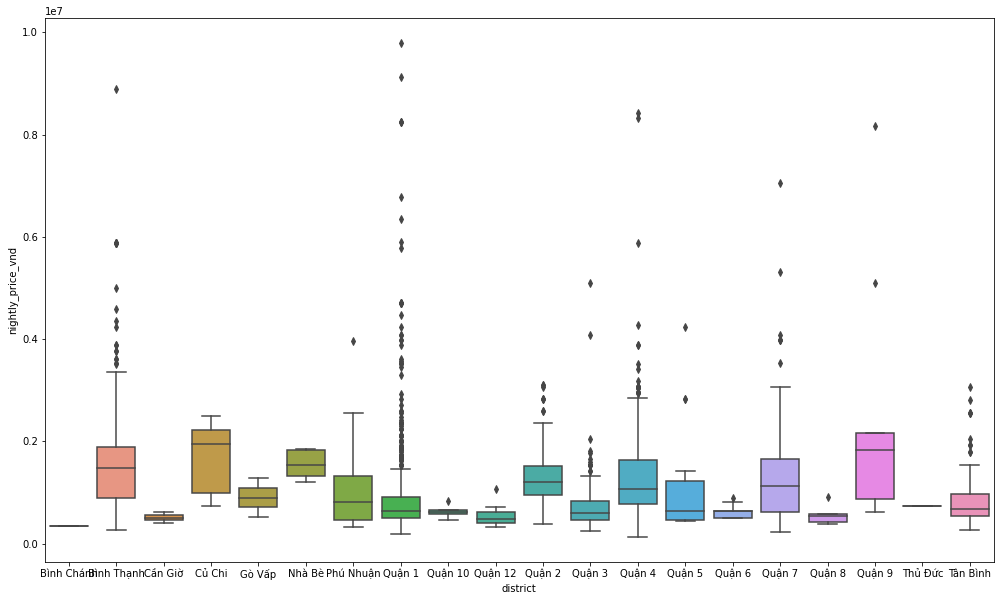

In [17]:
plt.figure(figsize=(17,10))
sns.boxplot(x='district', y='nightly_price_vnd', data=df)

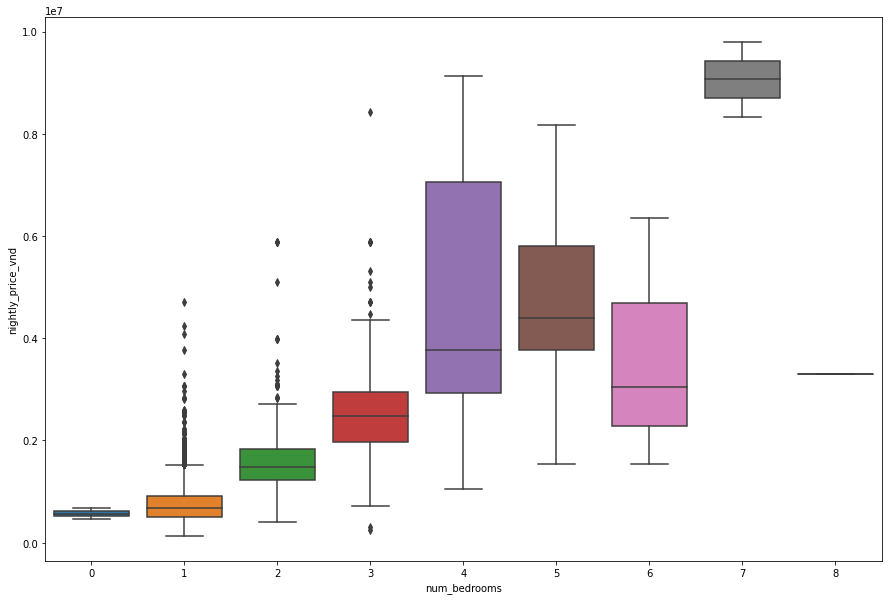

In [18]:
plt.figure(figsize=(15,10))
sns.boxplot(x='num_bedrooms', y='nightly_price_vnd', data=df)

**SUMMARY**
***
- 
- 
- 

## 2c. Mapping relationship between variables
***

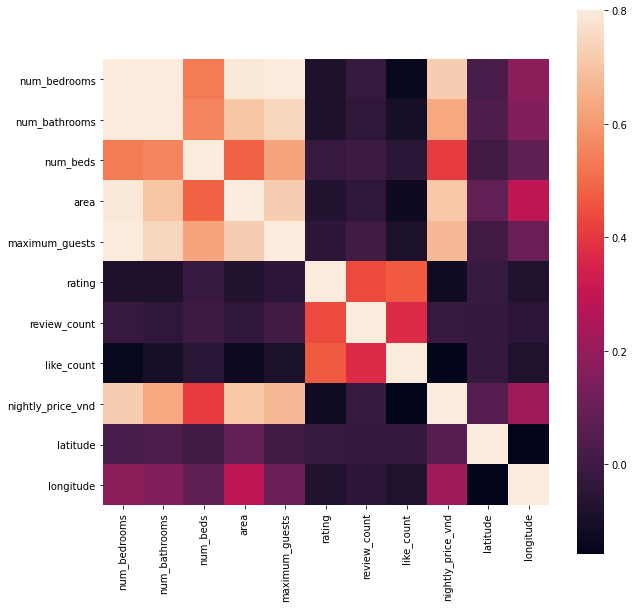

In [19]:
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmax=.8, square=True)

# 3. Modeling and prediction
***

'rating', 'review_count' and 'like_count' relationships with price are too incoherent that I don't think it'll be good to include them in our model, so we'll drop them

'ward' is just a more detailed represetation of 'district', the same can be said with 'latitude' and 'longitude'

In [ ]:
df_pred = df.drop(columns=['amenities', 'rating', 'review_count', 'like_count', 'latitude', 'longitude', 'ward'])

For other categorical value, we'll transform them using one hot coding to fit  with our model

In [20]:
df_pred = pd.get_dummies(df_pred,
                    columns=['bedType_name', 'roomType_name', 'propertyType_name', 'district'],
                    drop_first=True)  # To avoid dummy trap

In [34]:
# looks good now
df_pred.columns

Index(['num_bedrooms', 'num_bathrooms', 'num_beds', 'area', 'maximum_guests',
       'nightly_price_vnd', 'bedType_name_Couch', 'bedType_name_Futon',
       'bedType_name_King size', 'bedType_name_Queen Size',
       'bedType_name_Real Bed', 'bedType_name_Sofa Bed',
       'bedType_name_Twins Bed', 'roomType_name_Phòng riêng',
       'propertyType_name_Căn hộ Studio', 'propertyType_name_Căn hộ chung cư',
       'propertyType_name_Căn hộ dịch vụ', 'propertyType_name_Khác',
       'propertyType_name_Nhà riêng', 'district_Bình Thạnh',
       'district_Cần Giờ', 'district_Củ Chi', 'district_Gò Vấp',
       'district_Nhà Bè', 'district_Phú Nhuận', 'district_Quận 1',
       'district_Quận 10', 'district_Quận 12', 'district_Quận 2',
       'district_Quận 3', 'district_Quận 4', 'district_Quận 5',
       'district_Quận 6', 'district_Quận 7', 'district_Quận 8',
       'district_Quận 9', 'district_Thủ Đức', 'district_Tân Bình'],
      dtype='object')

In [22]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [23]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

Now we split our dataset to two, train set and test set, with a ratio of  8/2

In [24]:
# create train test split
x = df_pred.drop(columns='nightly_price_vnd')
y = df_pred['nightly_price_vnd']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

For this dataset, we'll use a simple regression model to test the water first, first choice would be linear regression since the variable we're predicting is continuous

In [25]:
# initialise our model
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Using sklearn *cross_val_score* to determine our model accuracy

In [37]:
# model performance
scores = cross_val_score(linreg, x_train, y_train, cv=10)
print(f'CV accuracy: {np.mean(scores)} +/- {np.std(scores)}')

CV accuracy: 0.542139080821293 +/- 0.12179115478727356


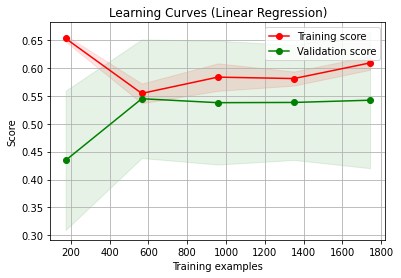

In [27]:
# Plot learning curves
plot_learning_curve(linreg,
                    title='Learning Curves (Linear Regression)',
                    X=x_train, y=y_train,
                    cv=10,
                    n_jobs=1);

**INSIGHT**
***
- Our model **overfits** as the examples applied increase, at 1800 points of data, the gap between training score and validation score widens. This can be mitigated by *feeding* more data into our model our *use less features*.
- Our model **underfits**, that is, both of our final scores are just slightly better then toss-a-coin blind guess. In this case, feeding more data is not helpful because the data isn't good enough to train the model, best bet is that we *collect another set of data*.

Next, we'll pass into the model a test dataset and compare our result with the actual result

In [53]:
y_pred = linreg.predict(x_test)

In [54]:
df_cv = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_cv

,Actual,Predicted
2145,1.648239e+06,1.832120e+06
931,1.295045e+06,7.856638e+05
1008,8.980547e+05,5.904278e+05
2125,8.163492e+05,1.384110e+06
777,8.163492e+05,9.580591e+05
...,...,...
1771,1.412776e+06,1.456908e+06
266,1.326597e+06,1.188242e+06
2285,2.335790e+06,1.726436e+06
30,5.886568e+05,6.645677e+05


In [57]:
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}')  
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')  
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')

Mean Absolute Error: 357720.14779575495
Mean Squared Error: 350564480954.02435
Root Mean Squared Error: 592084.8595885765


**INSIGHT**
***
- The RMS calculation are all over the place
- Perhaps our dataset is not adequate to properly train the model, more data are always welcome.
- Maybe our feature engineering is not good enough, some indepent variables might not have the best covariance with our predicting variable. Detailed visualisaton among them can provide us with more information on how to best select a feature

> Coupled with the cross validation score, we should be able to conclude that linear regression is **not ideal** for this scenario